In [1]:
#import statements
from SCAD import SCADLinear
from OtherClasses import ElasticNet, SqrtLasso

import torch
import pandas as pd
from scipy.linalg import toeplitz

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
import itertools

In [77]:
device = torch.device("cpu")
dtype = torch.float64

## Part 1 - SCAD Implementation

In [78]:
# load in data
data = pd.read_csv('./data/concrete.csv')
X = data.drop(columns='strength').values
y = data['strength'].values

In [79]:
# scale data
scaler = StandardScaler()
xscaled = scaler.fit_transform(X)
print(xscaled.shape)

# convert to pytorch tensor
x_tensor = torch.tensor(xscaled, dtype=dtype)
print(x_tensor.shape)
y_tensor = torch.tensor(y, dtype=dtype)
print(y_tensor.shape)

(1030, 8)
torch.Size([1030, 8])
torch.Size([1030])


In [80]:
# create model with SCADLinear class
model = SCADLinear(input_size=x_tensor.shape[1], lambda_val=0.1, a_val=5)
# fit model and run with hyperparams num_epochs and lr
model.fit(X=x_tensor, y=y_tensor.unsqueeze(1), num_epochs= 2000, learning_rate=0.3)

Epoch [1000/2000], Loss: 107.22723607418962
Epoch [2000/2000], Loss: 107.22723607418962


In [81]:
# create a set of predictions for the model
prediction = model.predict(x_tensor)
# print mse for each actual target value and each predicted value
mse(y_tensor, prediction)

107.19723607486017

In [82]:
# check coefficients from the model to see which features have the most impact
model.get_coefficients()
# in this case, cement, slag, age, ash and water are strong predictors
# The weaker predictors are superplastic, coarseagg, and fineagg

Parameter containing:
tensor([[12.5142,  8.9571,  5.6248, -3.1998,  1.7449,  1.4056,  1.6180,  7.2119]],
       dtype=torch.float64, requires_grad=True)

#### Now we want to find the best possible lambda value for our model

In [83]:
# search for best lambda value
# this was done as my functions are not scikit compliant, so no GridSearchCV
lambda_vals = np.arange(0.1,10,0.1)
each_mse = []

# append scores to each_mse
for i in lambda_vals:
    model = SCADLinear(input_size= x_tensor.shape[1], lambda_val= i, a_val=6)
    model.fit(X=x_tensor, y=y_tensor.unsqueeze(1), num_epochs = 1000, learning_rate = 0.3)
    each_mse.append(mse(y_tensor, model.predict(x_tensor)))

Epoch [1000/1000], Loss: 107.2322360750092
Epoch [1000/1000], Loss: 107.33723607545622
Epoch [1000/1000], Loss: 107.51223607247599
Epoch [1000/1000], Loss: 107.75723607724437
Epoch [1000/1000], Loss: 108.07223607486017
Epoch [1000/1000], Loss: 108.45723606532343
Epoch [1000/1000], Loss: 108.91223610823879
Epoch [1000/1000], Loss: 109.43723608439693
Epoch [1000/1000], Loss: 110.03223611300716
Epoch [1000/1000], Loss: 110.69723607486017
Epoch [1000/1000], Loss: 111.43223620837459
Epoch [1000/1000], Loss: 112.2372360367132
Epoch [1000/1000], Loss: 113.11223603671321
Epoch [1000/1000], Loss: 114.05723620837462
Epoch [1000/1000], Loss: 115.07158786891148
Epoch [1000/1000], Loss: 116.00547414059331
Epoch [1000/1000], Loss: 116.7449537742417
Epoch [1000/1000], Loss: 117.2900273269448
Epoch [1000/1000], Loss: 117.64069367021696
Epoch [1000/1000], Loss: 117.83451764740109
Epoch [1000/1000], Loss: 117.98434116334414
Epoch [1000/1000], Loss: 118.09777986379349
Epoch [1000/1000], Loss: 118.1748337

#### Figure for part 1

Text(0, 0.5, 'MSE')

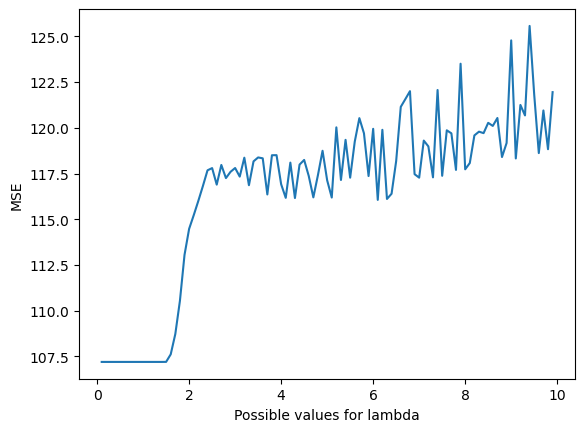

In [84]:
# plot mse score for each lambda value
fig, ax = plt.subplots()
ax.plot(lambda_vals, each_mse)
plt.xlabel('Possible values for lambda')
plt.ylabel('MSE')

We see that our best lambda values lie between 0 and roughly 1.5

## Part 2 - Compare SCAD with ElasticNet, sqrtLasso

In [85]:
# function to make n datasets with correlated features
def make_correlated_features(num_samples,p,rho):
  vcor = [] 
  for i in range(p):
    vcor.append(rho**i)
  r = toeplitz(vcor)
  mu = np.repeat(0,p)
  x = np.random.multivariate_normal(mu, r, size=num_samples)
  return x

In [86]:
num_samp = 200 # num observations
num_features = 8 # num features in data
corr_coeff = 0.9 # set a strong correlation between features

x = make_correlated_features(num_samp,num_features,corr_coeff)

In [87]:
# create sparcity pattern
beta = np.array([-1,2,3,0,0,2,-1])
beta = beta.reshape(-1,1)
# turn into matrix for multiplication
betastar = np.concatenate([beta,np.repeat(0,num_features-len(beta)).reshape(-1,1)],axis=0)

In [88]:
# set y to multiply x and betastar matrices
y = x@betastar + 1.5*np.random.normal(size=(num_samp,1))

In [89]:
# convert to tensors
x = torch.tensor(x,device=device)
y = torch.tensor(y,device=device)

In [90]:
# elastic net model
enet_model = ElasticNet(input_size=x.shape[1],alpha=0.01,l1_ratio=0.5)
enet_model.fit(x,y,num_epochs=2000,learning_rate=0.01)

Epoch [100/2000], Loss: 1.7686034707100609
Epoch [200/2000], Loss: 1.547509818414172
Epoch [300/2000], Loss: 1.4450635480767298
Epoch [400/2000], Loss: 1.3739252705234646
Epoch [500/2000], Loss: 1.3190112624343042
Epoch [600/2000], Loss: 1.2763439665257514
Epoch [700/2000], Loss: 1.242563301448177
Epoch [800/2000], Loss: 1.214867335337031
Epoch [900/2000], Loss: 1.1920634037185964
Epoch [1000/2000], Loss: 1.1732259521187522
Epoch [1100/2000], Loss: 1.1576229051086098
Epoch [1200/2000], Loss: 1.1446687978748604
Epoch [1300/2000], Loss: 1.133891716307954
Epoch [1400/2000], Loss: 1.1249089802145182
Epoch [1500/2000], Loss: 1.117408803855252
Epoch [1600/2000], Loss: 1.1111362030420602
Epoch [1700/2000], Loss: 1.1058820037453743
Epoch [1800/2000], Loss: 1.1014741683859974
Epoch [1900/2000], Loss: 1.0977708876897974
Epoch [2000/2000], Loss: 1.0946550389487177


In [91]:
# sqrtlasso model
sqlasso_model = SqrtLasso(input_size=x.shape[1],alpha=0.01)
sqlasso_model.fit(x,y,num_epochs=2000,learning_rate=0.01)

Epoch [100/2000], Loss: 2.3478517093560836


Epoch [200/2000], Loss: 1.9086950080797431
Epoch [300/2000], Loss: 1.785236612579972
Epoch [400/2000], Loss: 1.6951819021910461
Epoch [500/2000], Loss: 1.6199942923672062
Epoch [600/2000], Loss: 1.571374350093146
Epoch [700/2000], Loss: 1.538650486091581
Epoch [800/2000], Loss: 1.518233936456304
Epoch [900/2000], Loss: 1.505861208015853
Epoch [1000/2000], Loss: 1.498881545679566
Epoch [1100/2000], Loss: 1.495222876993509
Epoch [1200/2000], Loss: 1.494075883152405
Epoch [1300/2000], Loss: 1.4936442643116425
Epoch [1400/2000], Loss: 1.493456017714324
Epoch [1500/2000], Loss: 1.4933730911123801
Epoch [1600/2000], Loss: 1.4933355770423309
Epoch [1700/2000], Loss: 1.4933200612492248
Epoch [1800/2000], Loss: 1.4933142790747944
Epoch [1900/2000], Loss: 1.4933188073982584
Epoch [2000/2000], Loss: 1.4933145019092688


In [92]:
# scadlinear model
scad_model = SCADLinear(input_size=x_tensor.shape[1], lambda_val=0.001, a_val=8)
scad_model.fit(x,y,num_epochs=2000,learning_rate=0.01)

Epoch [1000/2000], Loss: 1.9953787617581293
Epoch [2000/2000], Loss: 1.9541988899914502


In [93]:
# print scores for each model
for model in [scad_model, enet_model, sqlasso_model]:
    score = mse(y_tensor.detach(), model.predict(x_tensor).detach())
    print(f'model: {model}\nscore: {score}')

model: SCADLinear(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)
score: 1597.1937244368708
model: ElasticNet(
  (linear): Linear(in_features=8, out_features=1, bias=False)
)
score: 1594.2803077149686
model: SqrtLasso(
  (linear): Linear(in_features=8, out_features=1, bias=False)
)
score: 1599.2401349213467


In [94]:
# create dictionary with coefficients from each model
coefficients = {'Original coefficients': betastar.flatten(),
                'SCADLinear': scad_model.get_coefficients().detach().numpy().flatten(),
                'ElasticNet': enet_model.get_coefficients().detach().numpy().flatten(),
                'SqrtLasso': sqlasso_model.get_coefficients().detach().numpy().flatten()}
# convert to pd dataframe and show
coef_df = pd.DataFrame(coefficients)
coef_df

,Original coefficients,SCADLinear,ElasticNet,SqrtLasso
0,-1,-1.195143,-0.843144,-1.105371
1,2,2.819058,2.468643,2.744691
2,3,2.812499,2.643758,2.742358
3,0,-0.016159,0.163928,-0.000252
4,0,-0.175675,0.006071,-0.042879
5,2,1.632564,1.242172,1.479681
6,-1,-0.701910,-0.409752,-0.653794
7,0,-0.020856,-0.106701,0.000081


In [119]:
# create dataframe with absolute difference from original coeff for each model
absolute_difference = coef_df.sub(coef_df['Original coefficients'], axis=0).abs()
absolute_difference

,Original coefficients,SCADLinear,ElasticNet,SqrtLasso
0,0,0.195143,0.156856,0.105371
1,0,0.819058,0.468643,0.744691
2,0,0.187501,0.356242,0.257642
3,0,0.016159,0.163928,0.000252
4,0,0.175675,0.006071,0.042879
5,0,0.367436,0.757828,0.520319
6,0,0.298090,0.590248,0.346206
7,0,0.020856,0.106701,0.000081


#### Figure for part 2

/var/folders/mq/89drrdjd1cv8ckjx8ljd6pm40000gn/T/ipykernel_5214/797264991.py:3: UserWarning: The label '_' of <BarContainer object of 8 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(['_', 'SCADLinear', 'ElasticNet', 'SqrtLasso'])


Text(0, 0.5, 'Absolute difference from betastar')

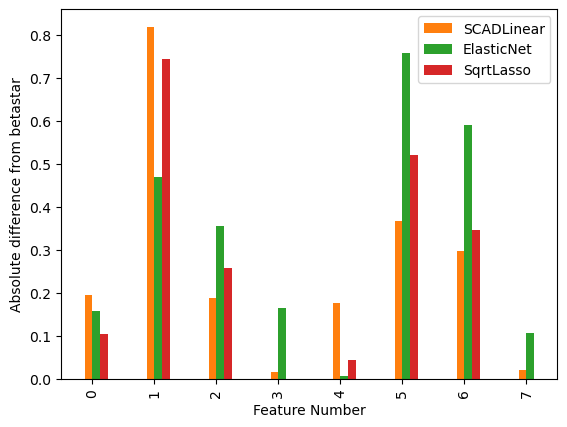

In [96]:
# plot absolute difference from betastar
absolute_difference.plot(kind='bar')
plt.legend(['_', 'SCADLinear', 'ElasticNet', 'SqrtLasso'])
plt.xlabel('Feature Number')
plt.ylabel('Absolute difference from betastar')

Here, we can see that SCAD performs better when the beta value != 0. However, when the beta value for the feature is set to 0, we see that both ElasticNet and SqrtLasso perform better

### Part 3 - Quadratic Interaction Terms

In [97]:
# read in data
data = pd.read_csv('./data/concrete.csv')

x = data.drop(columns='strength').values
y = data['strength'].values

# transform the data to include the quadratic terms
polynomial = PolynomialFeatures(degree=2, include_bias=False)
x_polynomial = polynomial.fit_transform(x)

In [99]:
# create scaler and fit to data
scaler = MinMaxScaler()
xscaled = scaler.fit_transform(x_polynomial)

# convert to tensor
x_tensor = torch.tensor(xscaled, dtype= dtype)
y_tensor = torch.tensor(y, dtype= dtype)

In [100]:
# attempt to find best values for lambda and a
lambda_vals = np.arange(0, 0.1, 0.02)
a_vals = np.arange(0, 8, 1)

# create a grid of parameters with possible lambda and a values
param_grid = list(itertools.product(lambda_vals, a_vals))
# empty list to store scores for each set of values
scores = []
# iterate to get scores for each set of values
for lambda_val,a_val in param_grid:
    model = SCADLinear(input_size = x_tensor.shape[1], lambda_val = lambda_val, a_val = a_val)
    model.fit(x_tensor, y_tensor.unsqueeze(1), num_epochs = 1000, learning_rate = 0.1)
    try:
        scores.append(mse(y_tensor, model.predict(x_tensor)))
    except ValueError as e: # was getting an error so I used a try/except block
        pass

Epoch [1000/1000], Loss: 69.89262443841983
Epoch [1000/1000], Loss: nan
Epoch [1000/1000], Loss: 69.90097373947233
Epoch [1000/1000], Loss: 69.88982275264517
Epoch [1000/1000], Loss: 69.89831013829392
Epoch [1000/1000], Loss: 69.89993904275266
Epoch [1000/1000], Loss: 69.9330189629832
Epoch [1000/1000], Loss: 69.87954650578857
Epoch [1000/1000], Loss: 69.9073733608343
Epoch [1000/1000], Loss: nan
Epoch [1000/1000], Loss: 69.89757414379348
Epoch [1000/1000], Loss: 69.91131151318974
Epoch [1000/1000], Loss: 69.89088018062742
Epoch [1000/1000], Loss: 69.86402849598194
Epoch [1000/1000], Loss: 69.89588759348652
Epoch [1000/1000], Loss: 69.88577693313862
Epoch [1000/1000], Loss: 69.88710148260607
Epoch [1000/1000], Loss: nan
Epoch [1000/1000], Loss: 69.92614174515087
Epoch [1000/1000], Loss: 69.90768650445519
Epoch [1000/1000], Loss: 69.91480805933581
Epoch [1000/1000], Loss: 69.91641297258354
Epoch [1000/1000], Loss: 69.91231318266934
Epoch [1000/1000], Loss: 69.9112679385383
Epoch [1000/1

In [101]:
scores.sort()
scores

[69.83774052522278,
 69.85384041475514,
 69.85895091489998,
 69.87027403103919,
 69.87053294781107,
 69.87346597179292,
 69.87508575546262,
 69.87517682599344,
 69.87728905487297,
 69.87889994751792,
 69.88081387867707,
 69.88086724581096,
 69.88174813570038,
 69.8836139869804,
 69.88548518834583,
 69.88796488867709,
 69.88929015605,
 69.88965160109755,
 69.89091906533834,
 69.891952558687,
 69.89295863822139,
 69.89546377573349,
 69.89584492269174,
 69.89770069151774,
 69.89813831670384,
 69.90149214836903,
 69.90167216310442,
 69.90177520618847,
 69.90259007356492,
 69.90301942522629,
 69.90886588786026,
 69.91164517815895,
 69.91431557728217,
 69.91469948711855,
 69.92397616735641]

Here we can see that all of the scores are just about the same, so it doesn't matter which vals we choose for lambda and a

This might be happening because of the learning rate? I'm not sure

In [102]:
# fit quadratic data to scadlinear model
model = SCADLinear(input_size=x_tensor.shape[1], lambda_val= 0.02, a_val= 4) # choosing values
model.fit(x_tensor, y_tensor.unsqueeze(1), num_epochs = 1000, learning_rate = 0.215)

Epoch [1000/1000], Loss: 63.75874417831619


In [103]:
# get coefficients
coef = model.get_coefficients()
coef

Parameter containing:
tensor([[ 14.8451,   4.2556,   1.2872,  -3.9686,   0.8450,   1.1284,   1.3558,
          18.4964,   4.9105,   5.8598,   7.1869,   4.5407,  -6.2135,  14.6421,
          10.5212,   6.8346, -10.2274,   2.7280,   6.4683,   5.9378,   1.4832,
          11.0869,  20.4661,  -9.0207,  -3.3865,  -4.7463,   3.4099,   6.2489,
          14.5664,  -2.5893,   6.4458, -11.9239,  -4.5722,  10.4705, -23.9837,
           7.1118,  -2.0943,  27.3222,   0.2767,   3.0898,  17.2855,  -4.7188,
          19.0477, -45.6391]], dtype=torch.float64, requires_grad=True)

In [104]:
scores = [] # store scores
threshold = 0.01 # close to 0 threshold when counting number of coefficients
coefficients_counted = [] # store number of coefficients counted in the model

# run k-fold cross-validation
kf = KFold(n_splits = 10)
for train_index, test_index in kf.split(x):
    x_train, x_test = x_polynomial[train_index], x_polynomial[test_index]
    y_train, y_test = y[train_index], y[test_index]

    x_train_scale = scaler.fit_transform(x_train)
    x_test_scale = scaler.fit_transform(x_test)

    model.fit(torch.tensor(x_train_scale), torch.tensor(y_train).unsqueeze(1), num_epochs = 1000, learning_rate = 0.2)
    y_predicted = model.predict(torch.tensor(x_test_scale))
    print(mse(y_test, y_predicted.detach().numpy()))

    # detach for values
    coef_np = model.get_coefficients().detach().numpy()
    # append values
    coefficients_counted.append(np.sum(np.abs(coef_np) > threshold))
    # append scores
    scores.append(mse(y_test, y_predicted.detach().numpy()))

Epoch [1000/1000], Loss: 50.10614966080122
215.9862802652697
Epoch [1000/1000], Loss: 56.09982575630228
138.86316411573262
Epoch [1000/1000], Loss: 59.88120154545312
239.34968094487593
Epoch [1000/1000], Loss: 53.22396082342516
86.28806132481164
Epoch [1000/1000], Loss: 54.92912078239388
442.2550199311224
Epoch [1000/1000], Loss: 59.849972549227864
164.93814655163155
Epoch [1000/1000], Loss: 60.20806535282083
215.4176228714256
Epoch [1000/1000], Loss: 58.550180462183604
100.42544716217817
Epoch [1000/1000], Loss: 59.27179346990425
305.9166178711234
Epoch [1000/1000], Loss: 59.90565740786691
2647.3652315482937


In [105]:
# print scores and num coefficients counted in the model
print(f'Cross-validated scores: {scores}')
print(f'Best number of coefficients: {coefficients_counted}')

Cross-validated scores: [215.9862802652697, 138.86316411573262, 239.34968094487593, 86.28806132481164, 442.2550199311224, 164.93814655163155, 215.4176228714256, 100.42544716217817, 305.9166178711234, 2647.3652315482937]
Best number of coefficients: [44, 44, 44, 44, 44, 44, 44, 44, 44, 44]


#### Figure for part 3

(40.0, 45.0)

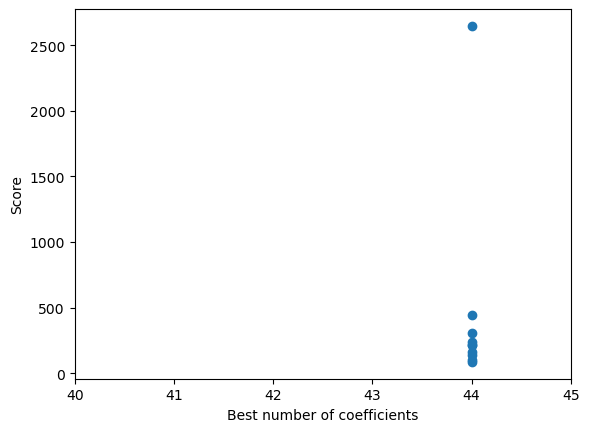

In [106]:
fig, ax = plt.subplots()
ax.scatter(coefficients_counted, scores)
plt.xlabel('Best number of coefficients')
plt.ylabel('Score')
plt.xlim([40, 45])